In [1]:
import json
import math
import random
import pickle
import time
from datetime import datetime
from itertools import count
from collections import OrderedDict, defaultdict, namedtuple
from joblib import Parallel, delayed
import multiprocessing
import cProfile

from tqdm.notebook import trange, tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

import gym

In [3]:
GAMMA = 1
ROWS_NUM = 3
COLS_NUM = 3
NUM_WIN = 3

In [4]:
class TicTacToe(gym.Env):
    def __init__(self, rows_num=ROWS_NUM, cols_num=COLS_NUM, win_num=NUM_WIN):
        self.rows_num = rows_num
        self.cols_num = cols_num
        self.win_num = win_num
        self.board = np.zeros((self.rows_num, self.cols_num), dtype=int)
        self.game_over = False
        self.board_hash = None
        self.cur_turn = 1
        self.empties = None
        self.reset()
        
    def move(self, player, i, j):
        self.board[i, j] = player
        self.empties = None
        self.board_hash = None

    def get_empties(self):
        if self.empties is None:
            res = np.where(self.board == 0)
            self.empties = np.array(
                [(i, j) for i,j in zip(res[0], res[1])]
            )
        return self.empties

    def get_hash(self):
        if self.board_hash is None:
            self.board_hash = ''.join(
                ['%s' % (x+1) for x in self.board.reshape(self.rows_num * self.cols_num)]
            )
        return self.board_hash

    def is_fin(self):
        cur_marks = np.where(self.board == self.cur_turn)
        cur_p = self.cur_turn
        for i, j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.rows_num - self.win_num:
                if np.all(self.board[i:i+self.win_num, j] == cur_p):
                    win = True
            if not win:
                if j <= self.cols_num - self.win_num:
                    if np.all(self.board[i,j:j+self.win_num] == cur_p):
                        win = True
            if not win:
                if i <= self.rows_num - self.win_num and j <= self.cols_num - self.win_num:
                    if np.all(
                        np.array(
                            [self.board[i+k,j+k] == cur_p for k in range(self.win_num)]
                        )
                    ):
                        win = True
            if not win:
                if i <= self.rows_num - self.win_num and j >= self.win_num - 1:
                    if np.all(
                        np.array(
                            [self.board[i+k,j-k] == cur_p for k in range(self.win_num)]
                        )
                    ):
                        win = True
            if win:
                self.game_over = True
                return self.cur_turn
        if len(self.get_empties()) == 0:
            self.game_over = True
            return 0

        self.game_over = False
        return 

    def get_state(self):
        res = (self.get_hash(), self.get_empties(), self.cur_turn)
        return res

    def get_act_from_int(self, act_int):
        res = (int(act_int / self.cols_num), int(act_int % self.cols_num))
        return res

    def get_int_from_act(self, act):
        res = act[0] * self.cols_num + act[1]
        return res
    
    def step(self, act):
        if self.board[act[0], act[1]] != 0:
            if self.cur_turn == 1:
                reward = -3
            else:
                reward = 3
            res = self.get_state(), reward, True, {}
            return res
        
        self.move(self.cur_turn, act[0], act[1])
        reward = self.is_fin()
        self.cur_turn = -self.cur_turn
        return self.get_state(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.rows_num, self.cols_num), dtype=int)
        self.board_hash = None
        self.game_over = False
        self.empties = None
        self.cur_turn = 1

In [5]:
def draw_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    X, Y = np.meshgrid(np.arange(0, env.rows_num), np.arange(0, env.rows_num))
    Z = np.zeros((env.rows_num, env.cols_num)) + 0.01
    s, actions = env.get_hash(), env.get_empties()
    
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
            
    ax.set_xticks([])
    ax.set_yticks([])
    
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i, a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text(
                    a[1],
                    a[0],
                    "%.3f" % pi.Q[s][i],
                    fontsize=fontq,
                    horizontalalignment='center',
                    verticalalignment='center',
                    color="w"
                )
    for i in range(env.rows_num):
        for j in range(env.cols_num):
            if env.board[i, j] == -1:
                ax.text(
                    j,
                    i,
                    "O",
                    fontsize=fontx,
                    horizontalalignment='center',
                    verticalalignment='center',
                    color="w"
                )
            if env.board[i, j] == 1:
                ax.text(
                    j,
                    i,
                    "X",
                    fontsize=fontx,
                    horizontalalignment='center',
                    verticalalignment='center',
                    color="w"
                )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

In [6]:
def get_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    draw_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Unknown")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi(s, env.cur_turn, len(actions))

In [7]:
def draw_test(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    done = False
    env.reset()
    
    while not done:
        s, actions = env.get_hash(), env.get_empties()
        if env.cur_turn == 1:
            a = get_print_move(
                env,
                pi1,
                s,
                actions,
                random=random_crosses,
                verbose=verbose,
                fontq=fontq,
                fontx=fontx
            )
        else:
            a = get_print_move(
                env,
                pi2,
                s,
                actions,
                random=random_naughts,
                verbose=verbose,
                fontq=fontq,
                fontx=fontx
            )
    
        print(a)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Crosses")
            draw_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Zeros")
            draw_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

In [8]:
env = TicTacToe()

In [9]:
def decay_epsilon_generator(min_eps=0.01, decay=0.99999):
    eps = 1
    while eps > min_eps:
        yield eps
        eps *= decay
    while 1:
        yield min_eps
        
def const_generator(eps):
    while True:
        yield eps

In [10]:
class Policy:
    def __init__(self, learning_rate=0.1):
        self.Q = dict()
        self.lr = learning_rate
        
    def __call__(self, s, player, n_a, eps=0): 
        if s not in self.Q:
            self.Q[s] = np.zeros(n_a, dtype=np.float32) - 1e-5
            
        r_num = np.random.random()
        if eps and r_num < eps:
            a = np.random.randint(0, n_a)
        else:
            if player == 1:
                a = np.argmax(self.Q[s])
            else:
                a = np.argmin(self.Q[s])
        return a
    
    def learn(self, s, player, a, n_a, reward, s_next, done):            
        if s not in self.Q:
            self.Q[s] = np.zeros(n_a, dtype=np.float32)
        if done:
            self.Q[s][a] += self.lr *(reward - self.Q[s][a])
        else:
            if s_next in self.Q:
                Q_max = np.min(self.Q[s_next]) if player == 1 else np.max(self.Q[s_next])
            else: 
                Q_max = - 1e-5
                
            self.Q[s][a] += self.lr * (GAMMA * Q_max - self.Q[s][a])


In [11]:
def run_episode(pi, eps_x, eps_o):
    env.reset()
    done = False
    s = env.get_hash()
    while not done:
        actions = env.get_empties()
        n_a = len(actions)
        player = env.cur_turn
        if player == 1:
            a = pi(s, player, n_a, eps_x)
        else:
            a = pi(s, player, n_a, eps_o)
        observation, reward, done, info = env.step(actions[a])
        s_prev, s = s, env.get_hash()
        
        if player == 1:
            pi.learn(s_prev, player, a, n_a, reward, s, done)
        else:
            pi.learn(s_prev, player, a, n_a, reward, s, done)
    return reward


In [12]:
def draw_reward(lines, legend=None):
    plt.rcParams["font.size"] = "14" 
    fig, ax = plt.subplots(figsize=(10, 6))
#     ax.set_facecolor("seashell")
    plt.ylabel("Aver reward")
    plt.xlabel("Iteration number")
    for x, y in lines:
        plt.plot(x, y)
    ax.set_yticks([-1.0, -0.75, -0.5, -0.25, -0.0, 0.25, 0.5, 0.75, 1.0])
    if legend is not None:
        ax.legend(legend)
    ax.grid(); plt.grid()
    plt.show()
    

In [13]:
def play_n_games(pi, x_ticks, eps_x, eps_o):
    mean_rewards = []
    running_reward = 0
    n_games = 0
    for i in trange(1, x_ticks[-1]+1):
        a = next(eps_x)
        b = next(eps_o)
        running_reward += run_episode(pi, a, b)
        n_games += 1
        if i in x_ticks:
            mean_rewards.append(running_reward / n_games)
            n_games = 0
            running_reward = 0
    return mean_rewards

In [14]:
x = (np.logspace(3, 6, 30).astype(np.int32) - 1000)[1:]
print("points:", x)

points: [   268    610   1043   1592   2290   3175   4298   5723   7531   9826
  12738  16433  21122  27072  34622  44203  56361  71789  91367 116210
 147735 187739 238502 302919 384662 488390 620016 787046 999000]


In [15]:
pi = Policy()
mean_rewards_o_const = play_n_games(pi, x, const_generator(1), const_generator(.05))

pi = Policy()
mean_rewards_o_decay = play_n_games(pi, x, const_generator(1), decay_epsilon_generator())

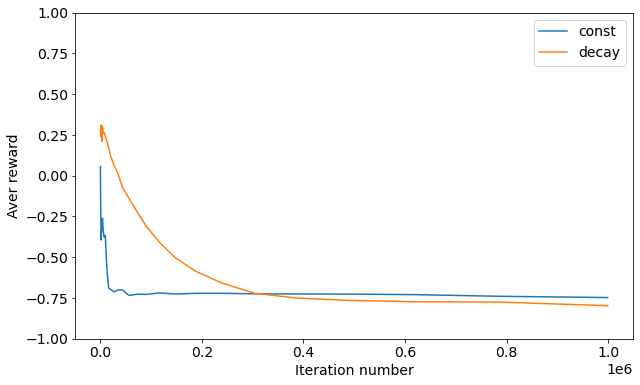

In [16]:
draw_reward([(x, mean_rewards_o_const), (x, mean_rewards_o_decay)], ['const', 'decay'])

In [17]:
x = (np.logspace(3, 4, 20).astype(np.int32) - 1000)[1:]
mean_rewards_xo_greed = play_n_games(pi, x, const_generator(0.01), const_generator(0.01))

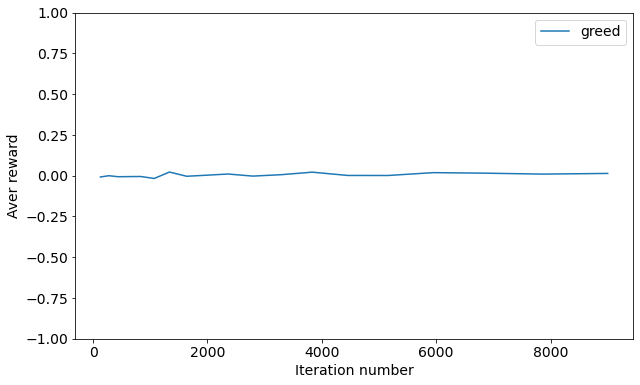

In [18]:
draw_reward([(x, mean_rewards_xo_greed)], ['greed'])

In [19]:
x = (np.logspace(3, 5, 30).astype(np.int32) - 1000)[1:]

pi = Policy()
mean_rewards_x_const = play_n_games(pi, x, const_generator(.05), const_generator(1))

pi = Policy()
mean_rewards_x_decay = play_n_games(pi, x, decay_epsilon_generator(), const_generator(1))

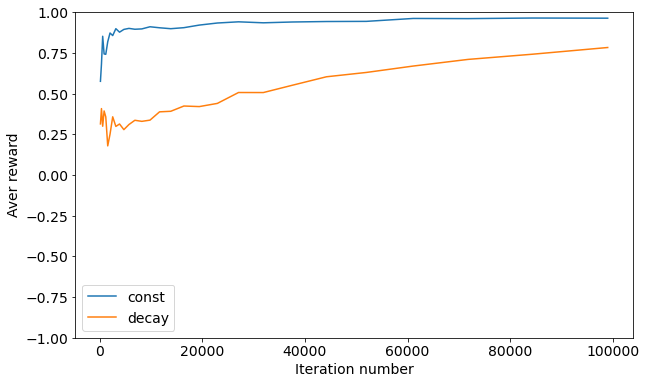

In [20]:
draw_reward([(x, mean_rewards_x_const), (x, mean_rewards_x_decay)], ['const', 'decay'])

In [21]:
x = (np.logspace(3, 4, 20).astype(np.int32) - 1000)[1:]
mean_rewards_xo_greed = play_n_games(pi, x, const_generator(0.01), const_generator(0.01))

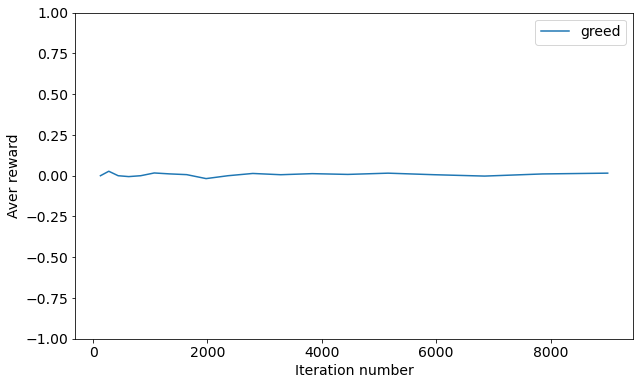

In [22]:
draw_reward([(x, mean_rewards_xo_greed)], ['greed'])

In [23]:
x = (np.logspace(3, 6, 30).astype(np.int32) - 10**3)[1:]

pi = Policy()
mean_rewards_xo_decay = play_n_games(pi, x, decay_epsilon_generator(), decay_epsilon_generator())

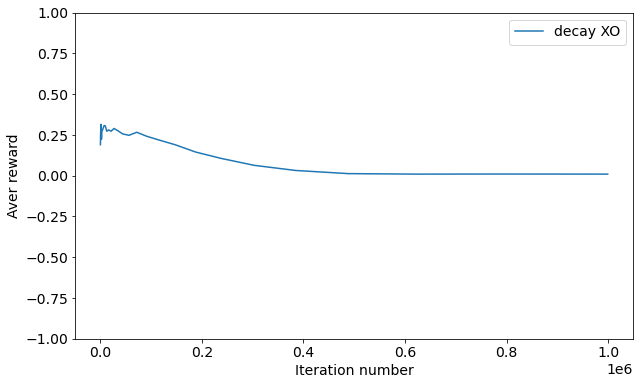

In [24]:
draw_reward([(x, mean_rewards_xo_decay)], ['decay XO'])

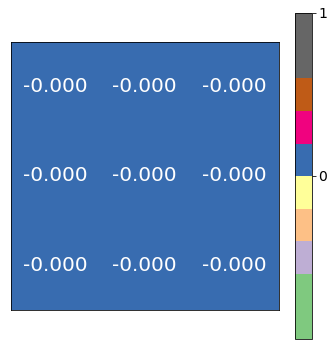

0 [0 0] -5e-44
1 [0 1] -4.46604e-40
2 [0 2] -5e-44
3 [1 0] -1.3145057e-35
4 [1 1] -3.945066e-39
5 [1 2] -9.134288e-33
6 [2 0] -5e-44
7 [2 1] -2.3840314e-31
8 [2 2] -5e-44
0


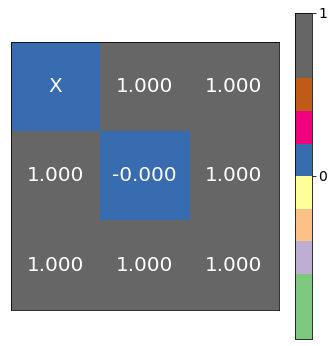

0 [0 1] 0.99999857
1 [0 2] 0.99999857
2 [1 0] 0.99999857
3 [1 1] -4.5e-44
4 [1 2] 0.99999857
5 [2 0] 0.99999857
6 [2 1] 0.99999857
7 [2 2] 0.99999857
3


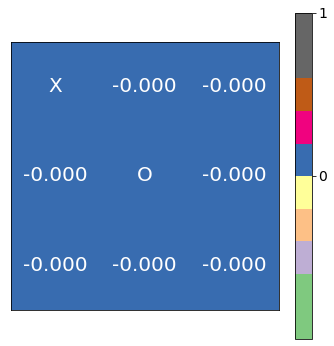

0 [0 1] -3.9e-44
1 [0 2] -9.448252e-30
2 [1 0] -3.9e-44
3 [1 2] -1.7019955e-25
4 [2 0] -3.9e-44
5 [2 1] -9.630671e-25
6 [2 2] -3.725577e-31
0


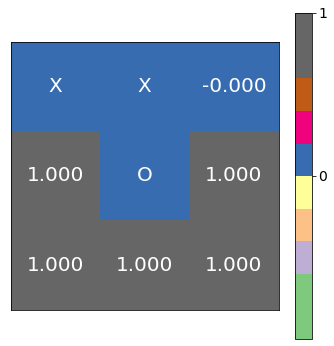

0 [0 2] -3.4e-44
1 [1 0] 0.9999995
2 [1 2] 0.9999995
3 [2 0] 0.9999995
4 [2 1] 0.9999995
5 [2 2] 0.9999995
0


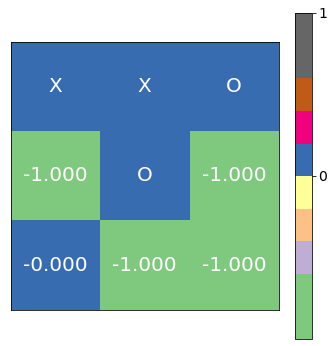

0 [1 0] -0.9999995
1 [1 2] -0.9999995
2 [2 0] -2.8e-44
3 [2 1] -0.9999995
4 [2 2] -0.9999995
2


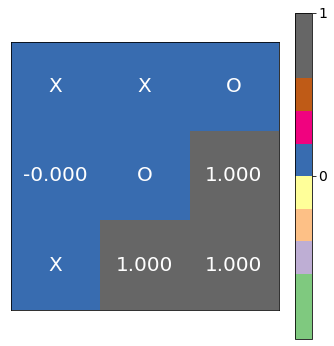

0 [1 0] -2.2e-44
1 [1 2] 0.9999995
2 [2 1] 0.9999995
3 [2 2] 0.9999995
0


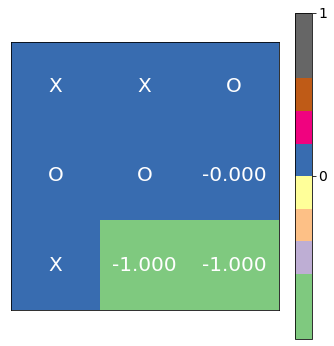

0 [1 2] -1.7e-44
1 [2 1] -0.9999995
2 [2 2] -0.9999995
0


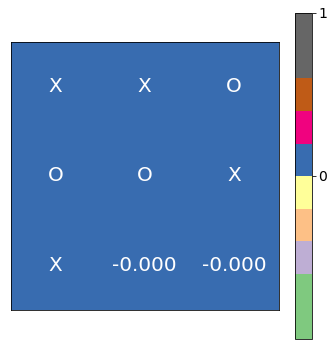

0 [2 1] -1.1e-44
1 [2 2] -1.1e-44
0


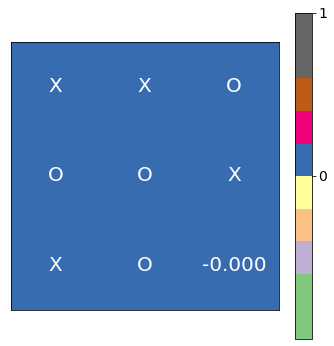

0 [2 2] -6e-45
0


In [25]:
draw_test(env, pi, pi, random_crosses=False, random_naughts=False, verbose=True, fontx=20)

In [26]:
env = TicTacToe(rows_num=5, cols_num=5, win_num=4)

In [27]:
x = (np.logspace(3, 5, 30).astype(np.int32) - 10**3)[1:]

pi = Policy()
mean_rewards_o_decay = play_n_games(pi, x, const_generator(1), decay_epsilon_generator())

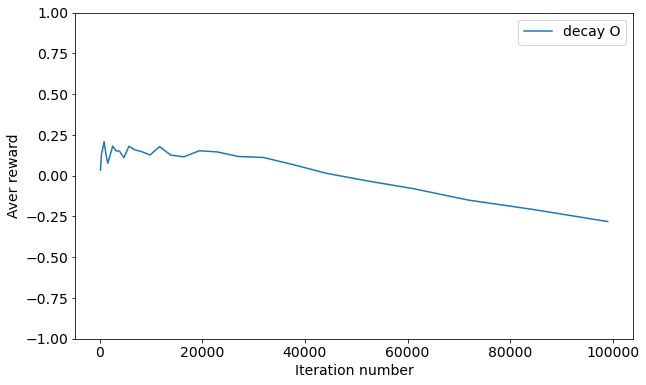

In [28]:
draw_reward([(x, mean_rewards_o_decay)], ['decay O'])

### Часть вторая

In [29]:
env = TicTacToe(rows_num=3, cols_num=3, win_num=3)

In [30]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = list()
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
            
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size=64):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)


In [31]:
class NN(nn.Module):
    def __init__(self, n_filters=384):
        nn.Module.__init__(self)
        self.conv = nn.Conv2d(1, n_filters, (3, 3))
        self.fc1 = nn.Linear(n_filters + 1, n_filters // 2)
        self.fc2 = nn.Linear(n_filters //2 , 9)

    def forward(self, state, player):
        x = F.relu(self.conv(state))
        x = torch.flatten(x, 1)
        batch_size = x.size(0)
        x = torch.cat((x, player.view(batch_size, 1)), dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [32]:
class DQN():
    def __init__(self, rows_num=3, cols_num=3, win_num=3):
        self.env = TicTacToe(rows_num, cols_num, win_num)
        self.model = NN()
        self.memory = ReplayMemory(10000)
        self.optimizer = optim.Adam(self.model.parameters(), 0.004)
        self.steps_done = 0
        self.gamma = 0.8
        self.eps_init = 0.9
        self.eps_final = 0.5
        self.eps_decay = 200
        self.num_step = 0
        
    def set_lr(self,lr):
        self.optimizer = optim.Adam(self.model.parameters(), lr)
    
    def select_greedy_action(self, state, player):
        if player.item() == 1.0:
            return self.model(state, player).max(1)[1].view(1)
        elif player.item() == -1.0:
            return self.model(state, player).min(1)[1].view(1)
        else:
            raise
    
    def select_action(self, state, player):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (
            self.eps_init - self.eps_final
        ) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            res = self.select_greedy_action(state, player.unsqueeze(0).unsqueeze(0))
        else:
            res = torch.tensor([[random.randrange(len(self.env.get_empties()))]], dtype=torch.int64)
        return res

    def run_episode(self, greedy_x=False, random_x=False, greedy_o=False, random_o=False, verbose=False):
        self.model.eval()
        self.env.reset()
        player_x = torch.tensor(1.0, dtype=torch.float32)
        player_o = torch.tensor(-1.0, dtype=torch.float32)
        state = prev_state = torch.Tensor(self.env.board).unsqueeze(0).unsqueeze(0)
        assert tuple(prev_state.size()) == (1, 1, 3, 3) 
        assert self.env.cur_turn == 1
        with torch.no_grad():
            player = player_x.detach().clone()
            if random_x:
                action_x = self.env.get_empties()[random.randrange(len(self.env.get_empties()))]
                action_x = torch.tensor(self.env.get_int_from_act(action_x)).view(1)            
            elif greedy_x:
                action_x = self.select_greedy_action(state, player)
            else:
                action_x = self.select_action(state, torch.ones(1)).view(1)

        _, reward_x, done, _ = self.env.step(
                self.env.get_act_from_int(action_x.item()))
        if verbose:
            print(self.env.board)
        state = torch.Tensor(self.env.board).unsqueeze(0).unsqueeze(0)
        assert tuple(state.size()) == (1, 1, 3, 3)
        while not done:
            if verbose:
                print('Zero')
            assert self.env.cur_turn == -1
            player = player_o.detach().clone()
            with torch.no_grad():
                if random_o:
                    action_o = self.env.get_empties()[random.randrange(len(self.env.get_empties()))]
                    action_o = torch.tensor(self.env.get_int_from_act(action_o)).view(1)
                elif greedy_o:
                    action_o = self.select_greedy_action(state, player)
                else:
                    action_o = self.select_action(state, player).view(1)
            _, reward_o, done, _ = self.env.step(
                    self.env.get_act_from_int(action_o.item()))
            next_state = torch.Tensor(self.env.board).unsqueeze(0).unsqueeze(0)
            if verbose:
                print(self.env.board)
            exptuple = (
                prev_state.detach().clone(),
                action_x,
                torch.Tensor([reward_x + reward_o]),
                next_state, 
                player_x.detach().clone(),
                torch.BoolTensor([done])  
            )
            self.memory.store(exptuple)
            if done:
                exptuple = (
                    state.detach().clone(),
                    action_o,
                    torch.Tensor([reward_o]),
                    next_state,
                    player_o.detach().clone(),
                    torch.BoolTensor([True])              
                )
                self.memory.store(exptuple)
                break            
            
            prev_state, state = state, next_state
            if verbose:
                print('Cross')
            assert self.env.cur_turn == 1
            player = player_x.detach().clone()
            with torch.no_grad():
                if random_x:
                    action_x = self.env.get_empties()[random.randrange(len(self.env.get_empties()))]
                    action_x = torch.tensor(self.env.get_int_from_act(action_x)).view(1)            
                elif greedy_x:
                    action_x = self.select_greedy_action(state, player)
                else:
                    action_x = self.select_action(state, player).view(1)
            _, reward_x, done, _ = self.env.step(
                self.env.get_act_from_int(action_x.item()))
            next_state = torch.Tensor(self.env.board).unsqueeze(0).unsqueeze(0)
            if verbose:
                print(self.env.board)
            exptuple = (
                prev_state.detach().clone(),
                action_o,
                torch.Tensor([reward_x + reward_o]),
                next_state,
                player_o.detach().clone(),
                torch.BoolTensor([done])
            )
            self.memory.store(exptuple)
            if done:
                exptuple = (
                    state.detach().clone(),
                    action_x,
                    torch.Tensor([reward_x]),
                    next_state,
                    player_x.detach().clone(),
                    torch.BoolTensor([True]) 
                )
                self.memory.store(exptuple)
                break       
            prev_state, state = state, next_state
        return reward_x + reward_o
        
    def learn(self, batch_size):
        self.model.train()
        if len(self.memory) < batch_size:
            return
        
        exp_batch = list(zip(*self.memory.sample(batch_size)))   
        batch_state = Variable(torch.cat(exp_batch[0]))
        batch_action = Variable(torch.stack(exp_batch[1]))
        batch_reward = Variable(torch.stack(exp_batch[2]))
        batch_next_state = Variable(torch.cat(exp_batch[3]))
        batch_player = Variable(torch.stack(exp_batch[4]))
        batch_done = Variable(torch.stack(exp_batch[5]))
        Q = self.model(batch_state, batch_player).gather(1, batch_action).reshape([batch_size])
        Qmax = self.model(batch_next_state, batch_player).detach().max(1)[0]
        Qmin = self.model(batch_next_state, batch_player).detach().min(1)[0]
        assert batch_player.size() == Qmax.size() == Qmin.size()
        Qmm = torch.where(batch_player > 0, Qmax, Qmin).view(-1, 1) * self.gamma
        assert batch_done.size() == batch_reward.size() == Qmm.size()
        Qnext = torch.where(batch_done, batch_reward, Qmm).view(-1)     
        loss = F.mse_loss(Q, Qnext)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss
        

In [33]:
game = DQN()

In [34]:
running_reward_x = 0
for i in range(1000):
    running_reward_x += game.run_episode(greedy_x=True, random_o=True)

In [35]:
running_reward_o = 0
for i in range(1000):
    running_reward_o += game.run_episode(greedy_o=True, random_x=True)

In [36]:
best_reward = running_reward_x / 1000 - running_reward_o/1000 
print('Init reward is: ', best_reward)

Init reward is:  -5.962


In [37]:
best_model = game.model.state_dict()

n_epochs = 50
for i in range(n_epochs):
    running_reward_o = 0
    running_reward_x = 0
    running_loss = 0
    for k in range(100):
        for l in range(10):
            game.run_episode()
        running_reward_o += game.run_episode(greedy_o=True, random_x=True)
        running_reward_x += game.run_episode(random_o=True, greedy_x=True)
        game.run_episode(random_o=True)
        game.run_episode(random_x=True)
        game.run_episode(greedy_x=True, greedy_o=True)
        running_loss += game.learn(512).item()
        
    reward = running_reward_x / 100 - running_reward_o / 100
    if reward > best_reward:
        best_model = game.model.state_dict()
    
    loss = running_loss / 100
    print(f"Epoch num is: {i}, reward is: {reward:.3f}, loss is: {loss:.3f}")

Epoch num is: 0, reward is: -5.560, loss is: 2.425
Epoch num is: 1, reward is: -5.360, loss is: 2.855
Epoch num is: 2, reward is: -4.400, loss is: 1.922
Epoch num is: 3, reward is: -2.270, loss is: 1.033
Epoch num is: 4, reward is: -0.210, loss is: 0.760
Epoch num is: 5, reward is: -0.350, loss is: 0.711
Epoch num is: 6, reward is: 0.010, loss is: 0.688
Epoch num is: 7, reward is: 0.270, loss is: 0.667
Epoch num is: 8, reward is: 0.530, loss is: 0.642
Epoch num is: 9, reward is: 0.150, loss is: 0.654
Epoch num is: 10, reward is: 0.730, loss is: 0.649
Epoch num is: 11, reward is: 0.540, loss is: 0.644
Epoch num is: 12, reward is: 0.760, loss is: 0.635
Epoch num is: 13, reward is: 0.610, loss is: 0.633
Epoch num is: 14, reward is: 0.610, loss is: 0.649
Epoch num is: 15, reward is: 0.760, loss is: 0.651
Epoch num is: 16, reward is: 0.530, loss is: 0.640
Epoch num is: 17, reward is: 0.690, loss is: 0.633
Epoch num is: 18, reward is: 0.780, loss is: 0.629
Epoch num is: 19, reward is: 0.840,

In [38]:
game.model.load_state_dict(best_model)
game.set_lr(0.0005)

In [39]:
n_epochs = 50
for i in range(n_epochs):
    running_reward_o = 0
    running_reward_x = 0
    running_loss = 0
    for m in range(100):
        for l in range(10):
            game.run_episode()
        running_reward_o += game.run_episode(greedy_o=True, random_x=True)
        running_reward_x += game.run_episode(random_o=True, greedy_x=True)
        game.run_episode(random_o=True)
        game.run_episode(random_x=True)
        game.run_episode(greedy_x=True, greedy_o=True)
        running_loss += game.learn(512).item()
    
    reward = running_reward_x / 100 - running_reward_o / 100
    if reward > best_reward:
        best_model = game.model.state_dict()
    
    loss = running_loss / 100
    print(f"Epoch num is: {i}, reward is: {reward:.3f}, loss is: {loss:.3f}")


Epoch num is: 0, reward is: 0.780, loss is: 0.654
Epoch num is: 1, reward is: 0.780, loss is: 0.689
Epoch num is: 2, reward is: 1.010, loss is: 0.670
Epoch num is: 3, reward is: 1.160, loss is: 0.649
Epoch num is: 4, reward is: 1.200, loss is: 0.646
Epoch num is: 5, reward is: 1.390, loss is: 0.638
Epoch num is: 6, reward is: 1.080, loss is: 0.619
Epoch num is: 7, reward is: 0.940, loss is: 0.619
Epoch num is: 8, reward is: 0.970, loss is: 0.618
Epoch num is: 9, reward is: 1.370, loss is: 0.630
Epoch num is: 10, reward is: 1.470, loss is: 0.628
Epoch num is: 11, reward is: 1.110, loss is: 0.629
Epoch num is: 12, reward is: 1.280, loss is: 0.635
Epoch num is: 13, reward is: 1.340, loss is: 0.645
Epoch num is: 14, reward is: 1.410, loss is: 0.635
Epoch num is: 15, reward is: 1.340, loss is: 0.647
Epoch num is: 16, reward is: 1.460, loss is: 0.632
Epoch num is: 17, reward is: 1.110, loss is: 0.631
Epoch num is: 18, reward is: 1.180, loss is: 0.618
Epoch num is: 19, reward is: 1.400, loss 

In [40]:
running_reward_x = 0
for i in range(5000):
    running_reward_x += game.run_episode(greedy_x=True, random_o=True)

In [41]:
running_reward_o = 0
for i in range(5000):
    running_reward_o += game.run_episode(greedy_o=True, random_x=True)

In [42]:
print('Best reward X is: ', running_reward_x / 5000, 'Best reward O is: ', running_reward_o / 5000)

Best reward X is:  0.9074 Best reward O is:  -0.4542


In [43]:
game.model.load_state_dict(best_model)

<All keys matched successfully>

In [44]:
running_reward_x = 0
for i in range(5000):
    running_reward_x += game.run_episode(greedy_x=True, random_o=True)

In [45]:
running_reward_o = 0
for i in range(5000):
    running_reward_o += game.run_episode(greedy_o=True, random_x=True)

In [46]:
 print('Best reward X is: ', running_reward_x / 5000, 'Best reward O is: ', running_reward_o / 5000)

Best reward X is:  0.8974 Best reward O is:  -0.4446


In [47]:
game.run_episode(verbose=True)

[[0 0 0]
 [0 0 1]
 [0 0 0]]
Zero
[[ 0  0 -1]
 [ 0  0  1]
 [ 0  0  0]]
Cross
[[ 0  0 -1]
 [ 0  0  1]
 [ 1  0  0]]
Zero
[[ 0  0 -1]
 [ 0 -1  1]
 [ 1  0  0]]
Cross
[[ 1  0 -1]
 [ 0 -1  1]
 [ 1  0  0]]
Zero
[[ 1  0 -1]
 [-1 -1  1]
 [ 1  0  0]]
Cross
[[ 1  1 -1]
 [-1 -1  1]
 [ 1  0  0]]
Zero
[[ 1  1 -1]
 [-1 -1  1]
 [ 1  0 -1]]
Cross
[[ 1  1 -1]
 [-1 -1  1]
 [ 1  1 -1]]


0

In [48]:
running_reward = 0
for _ in range(5000):
    running_reward += game.run_episode()

In [49]:
print('Best reward is: ', running_reward / 5000)

Best reward is:  0.0404
